(cifar10-resnet18-silu)=
# Cifar10 上的 ReNet18(SiLU)

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [56]:
import logging
import torch
from torch.fx.node import Argument
from typing import Any
from torch import nn, fx
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存
from torch_book.transforms.cutout import Cutout

def _create_model():
    """模型加载"""
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                            model.conv1.out_channels, 
                            3, 1, 1)
    model.maxpool = nn.Identity() #nn.Conv2d(64, 64, 1, 1, 1)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def replace(model):
    mod = fx.symbolic_trace(model)
    # 遍历 Graph 中全部节点
    for node in mod.graph.nodes:
        # 如果匹配目标
        if node.op == "call_module":
            if "relu" in node.target:
                # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
                with mod.graph.inserting_after(node):
                    new_node = mod.graph.call_function(torch.nn.functional.silu, node.args, node.kwargs)
                    node.replace_all_uses_with(new_node)
                # 移除 graph 中旧的节点
                mod.graph.erase_node(node)
    mod.graph.lint()
    # 不用忘记 recompile！
    new_code = mod.recompile()
    return mod


logging.basicConfig(filename='logs/debug-graph-silu.log',
                    filemode="a",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

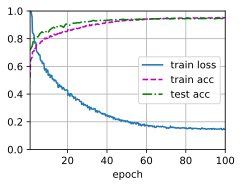

In [61]:
num_epochs = 100

data = Cifar10(batch_size = 32, cutout=Cutout(1, 16), num_workers=8)
train_iter = data.train_loader()
test_iter = data.val_loader()

model = _create_model()
model = replace(model)

classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [63]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9464

In [64]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_silu_cutout.h5')

In [ ]:
example_inputs = torch.rand(1, 3, 32, 32)
m = torch.jit.trace(classifier.mod.cpu(), example_inputs)
torch.jit.save(m, 'params/resnet18_cifar10_silu_cutout.pt')

## 性能度量

In [65]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()       
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        classifier.mod(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2023-11-22 16:31:01 3341947:3341947 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-22 16:31:01 3341947:3341947 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-22 16:31:01 3341947:3341947 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         5.50%       3.632ms        99.67%      65.845ms      65.845ms       0.000us         0.00%       1.515ms       1.515ms             1  
                                           aten::conv2d         0.17%     113.000us        88.27%      58.312ms       2.916ms       0.000us         0.00%       1.374ms      68.700us            20  
         